In [33]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind
from tqdm import tqdm

from src.tools.plotter import plot_p_gradient, init_plots
from src.tvla.accu import TvlaAccu
from src.tvla.t import make_t_test

init_plots()

In [2]:
TRACE_LEN = 100
DIST = lambda: np.random.normal(80, 2.2,size=TRACE_LEN).astype(int)
DIST2 = lambda: np.random.normal(82, 2.2,size=TRACE_LEN).astype(int)

In [29]:
def plot_mean(dists, amount, save_fig=True, frame=-1):
    if frame < 0:
        frame = amount

    if amount < 25:
        for dist_ix, dist in enumerate(dists):
            color = sns.color_palette()[dist_ix]

            for trace_ix in range(amount):
                sns.lineplot(data=dist[trace_ix], alpha=1/(amount ** 1.5), color=color)

    d = dict([(f"Mean {chr(65 + ix)}", dists[ix, :amount].mean(axis=0)) for ix in range(len(dists))])
    g = sns.lineplot(data=d)

    g.set(ylim=(75,85), xlabel="Sample point", ylabel="Power consumption, int8",
          title=f"Means of {amount} traces")
    [l.set_linestyle('-') for l in g.lines]
    g.legend()
    plt.legend(loc='upper right')

    if save_fig:
        g.get_figure().savefig(f'.cache/means/{str(frame).zfill(5)}')
        g.get_figure().clf()

DISTS = np.array([np.random.normal(80, 2.2,size=(1000, TRACE_LEN)) for _ in range(2)])
DISTS[0] -= [np.sin(np.linspace(0, np.pi, 100))] * 1000
DISTS[1] += [np.sin(np.linspace(0, np.pi, 100))] * 1000

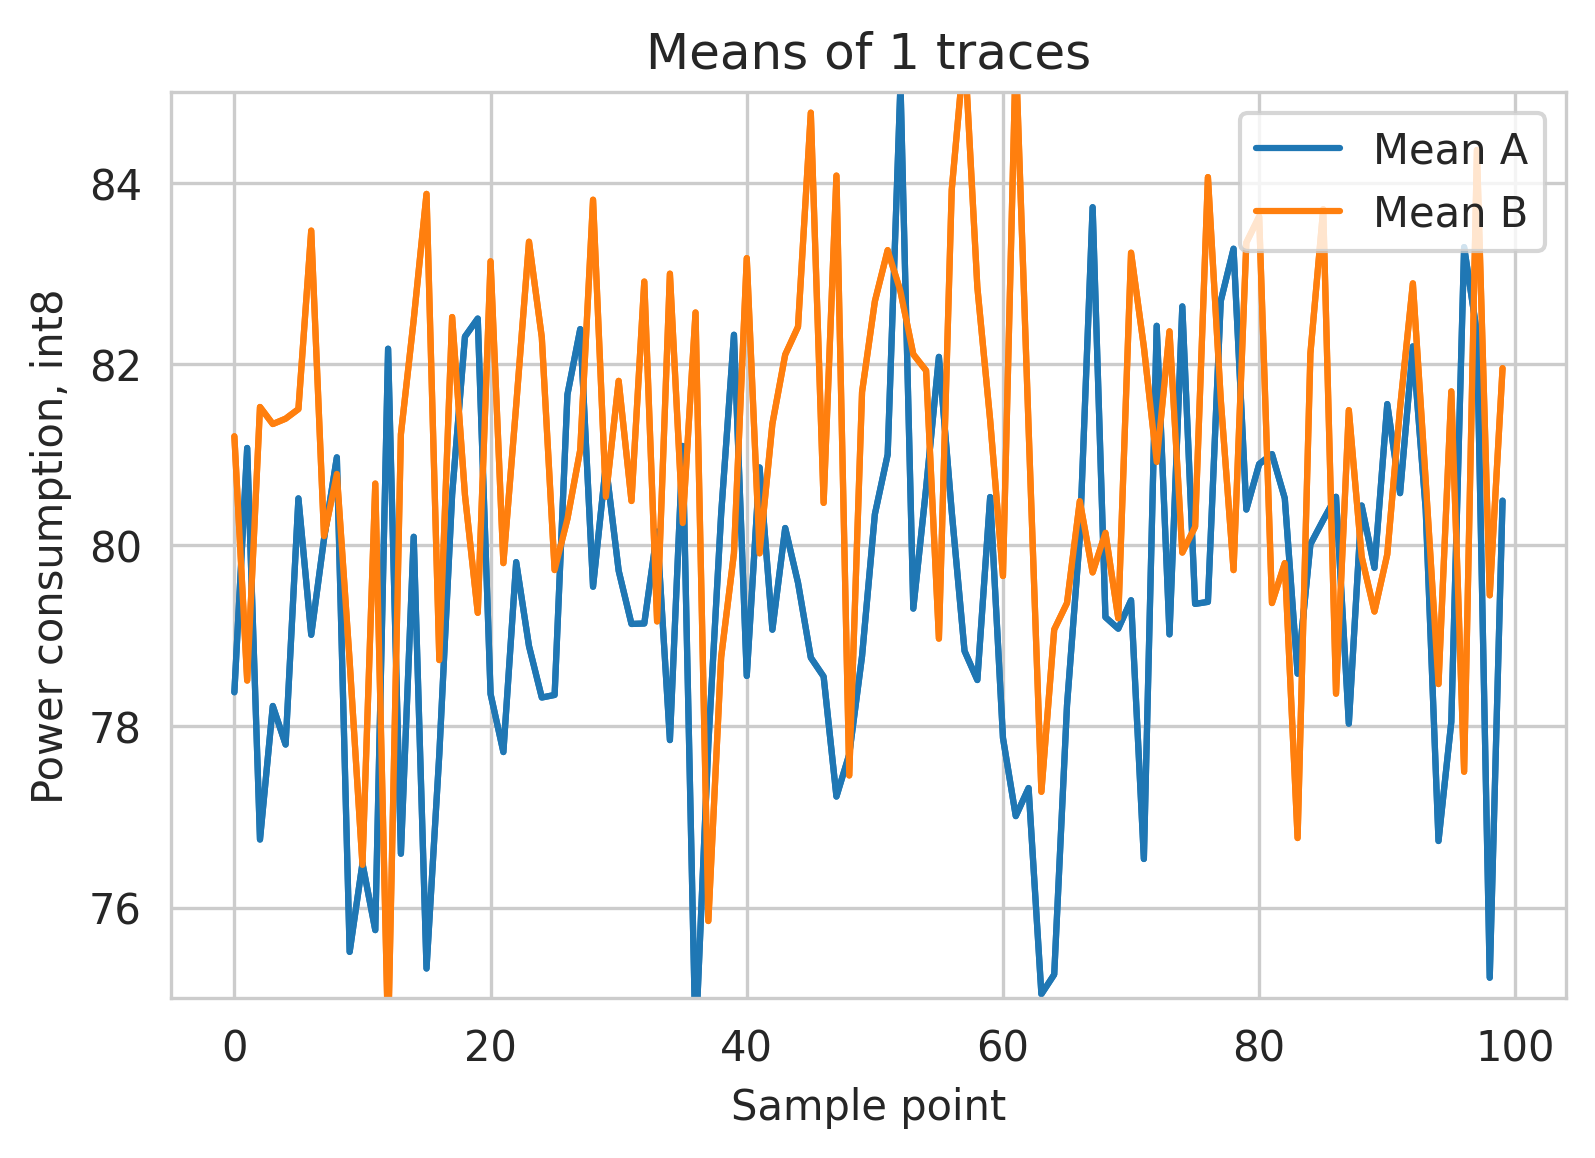

In [79]:
plot_mean(DISTS, 1, False)

In [31]:
# [plot_mean(DISTS, amount, frame=frame) for frame, amount in tqdm(enumerate(np.logspace(.1, 3, 1000).astype(int)))] and None

1000it [05:48,  2.87it/s]


<Figure size 1800x1200 with 0 Axes>

Render video by running

```
ffmpeg -framerate 50 -i %05d.png -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p output.mp4
```

In `./.cache/means`


[Text(0.5, 1.0, 'Distribution of A and B at sample point 50'),
 Text(0.5, 0, 'Power consumption')]

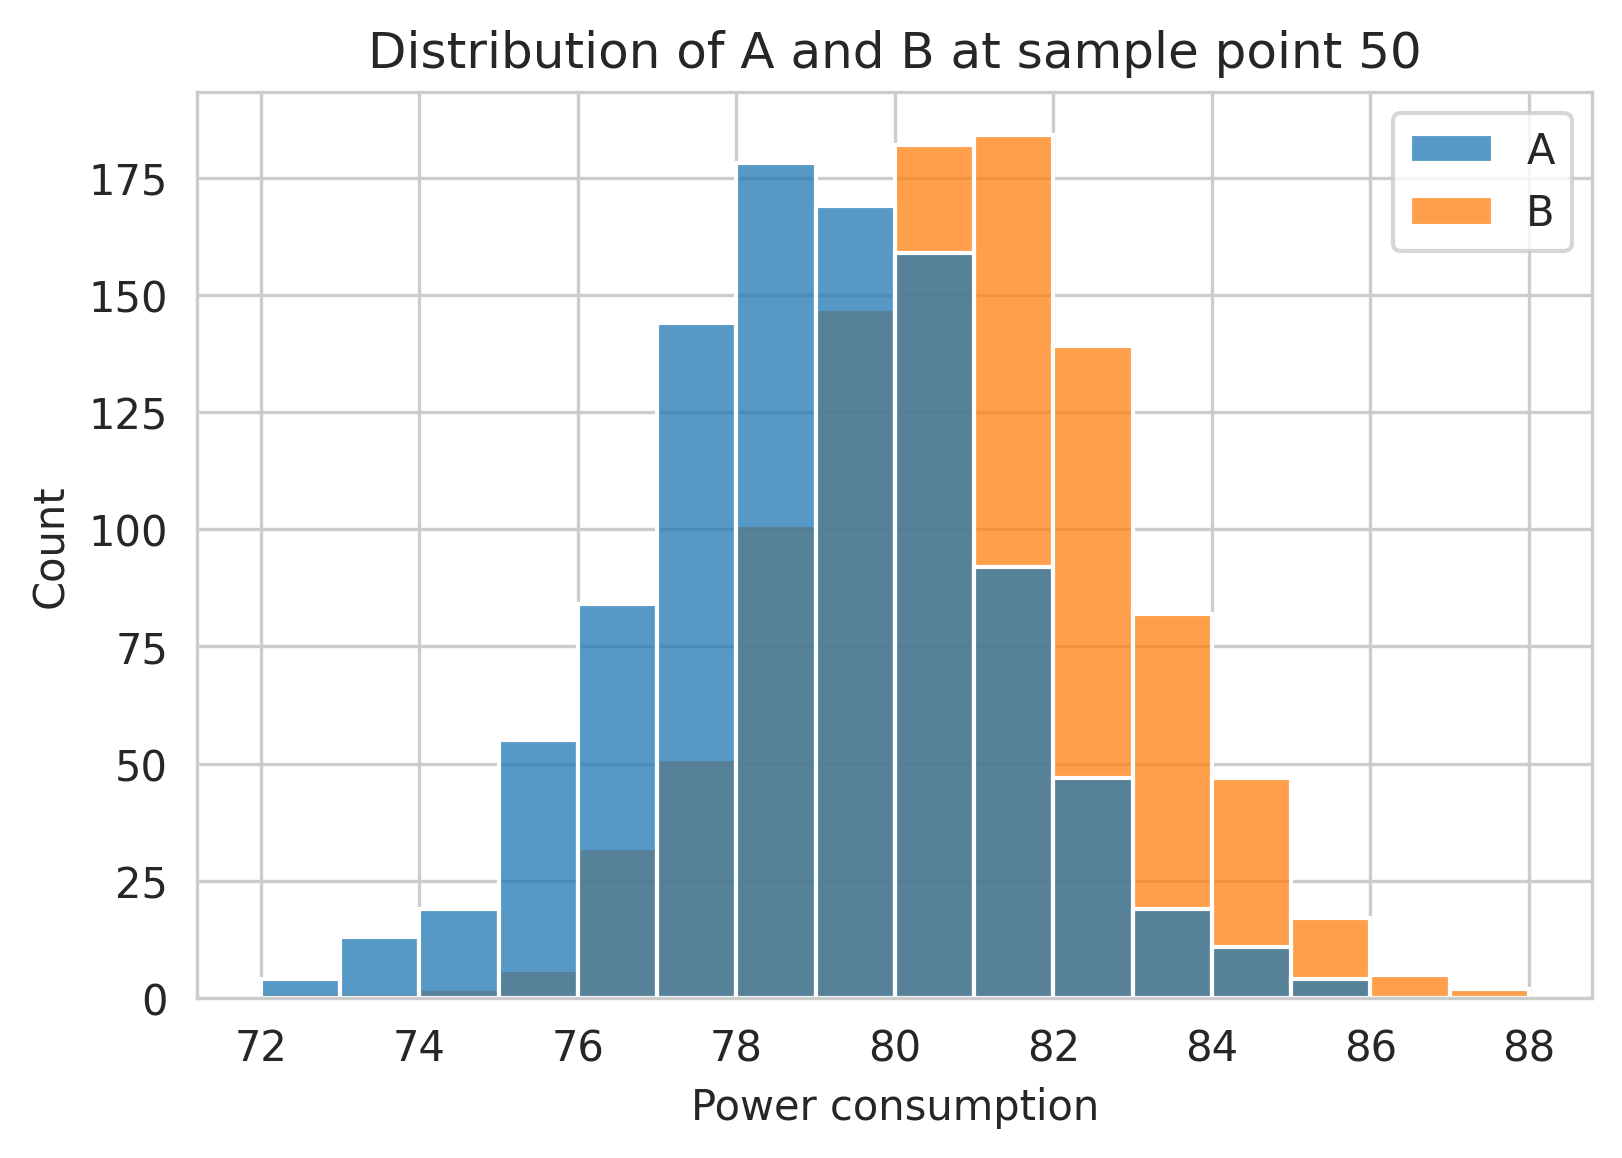

In [71]:
G = sns.histplot(data={"A": DISTS[0, :, 50], "B": DISTS[1, :, 50]}, bins=16, binrange=(72, 88))
G.set(title="Distribution of A and B at sample point 50", xlabel="Power consumption")

[Text(0.5, 1.0, 'Distribution of A and B at sample point 0'),
 Text(0.5, 0, 'Power consumption')]

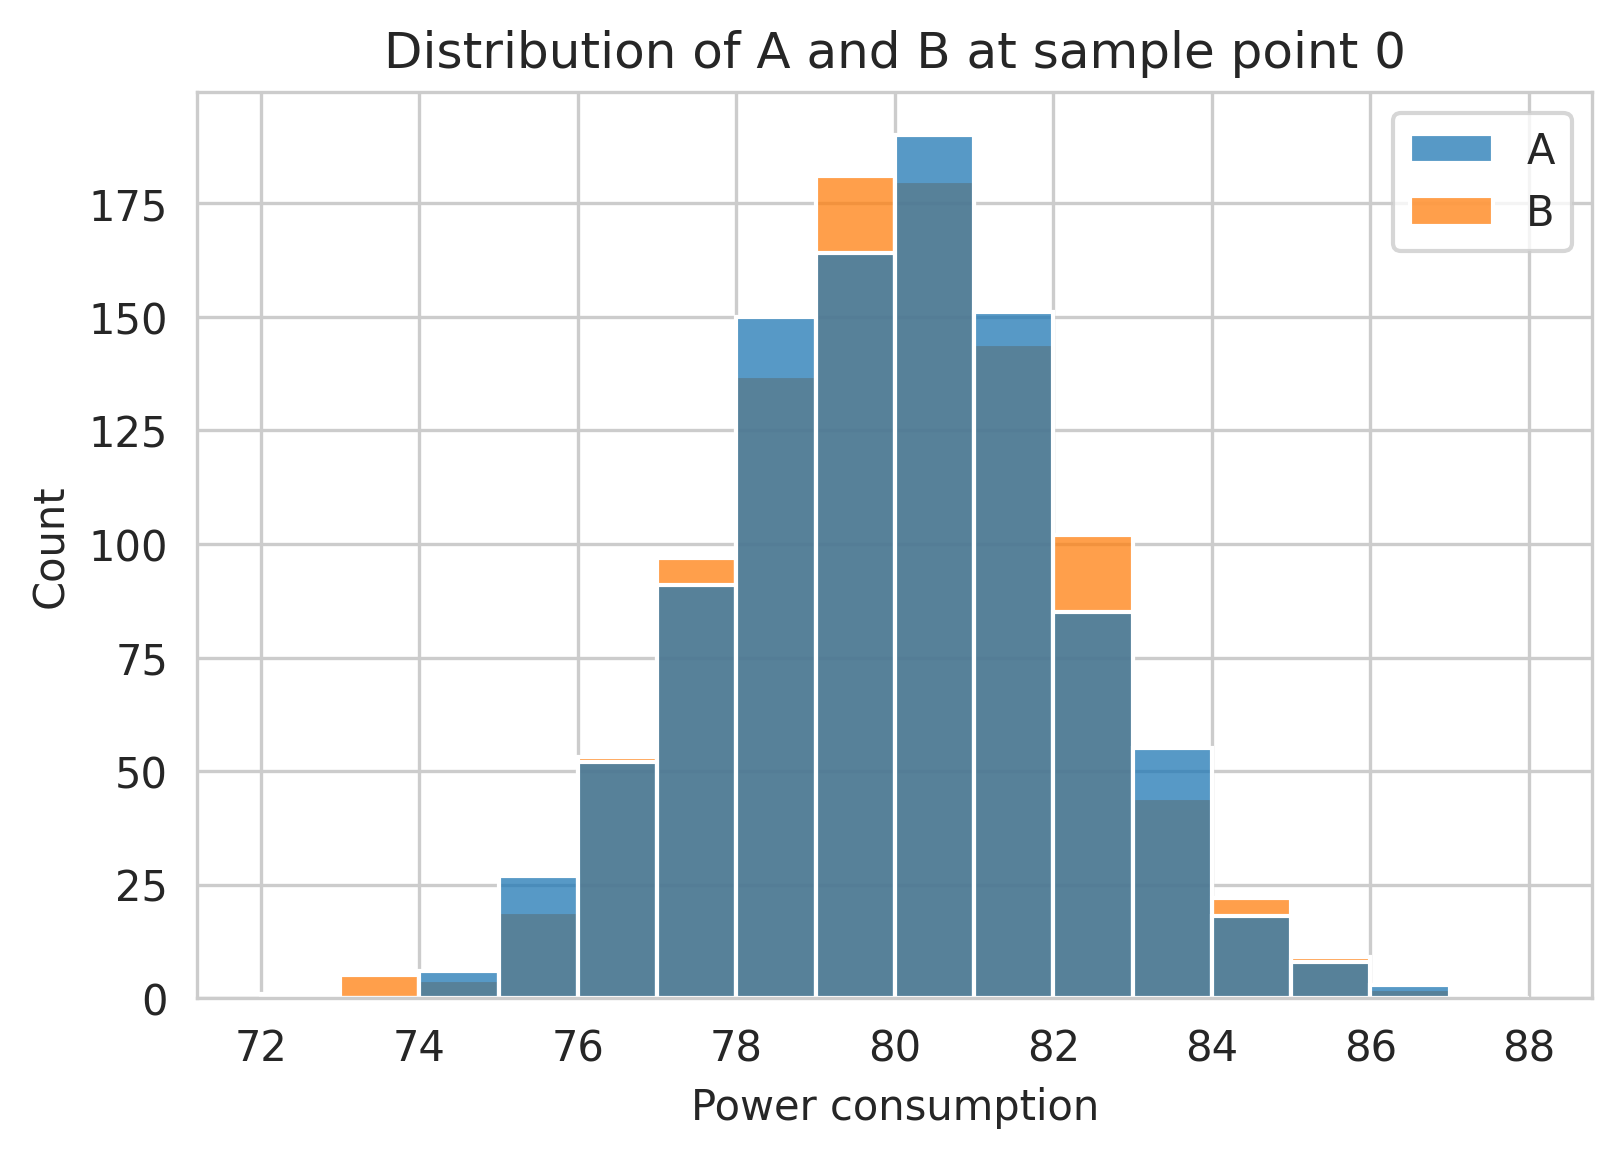

In [72]:
G = sns.histplot(data={"A": DISTS[0, :, 0], "B": DISTS[1, :, 0]}, bins=16, binrange=(72, 88))
G.set(title="Distribution of A and B at sample point 0", xlabel="Power consumption")

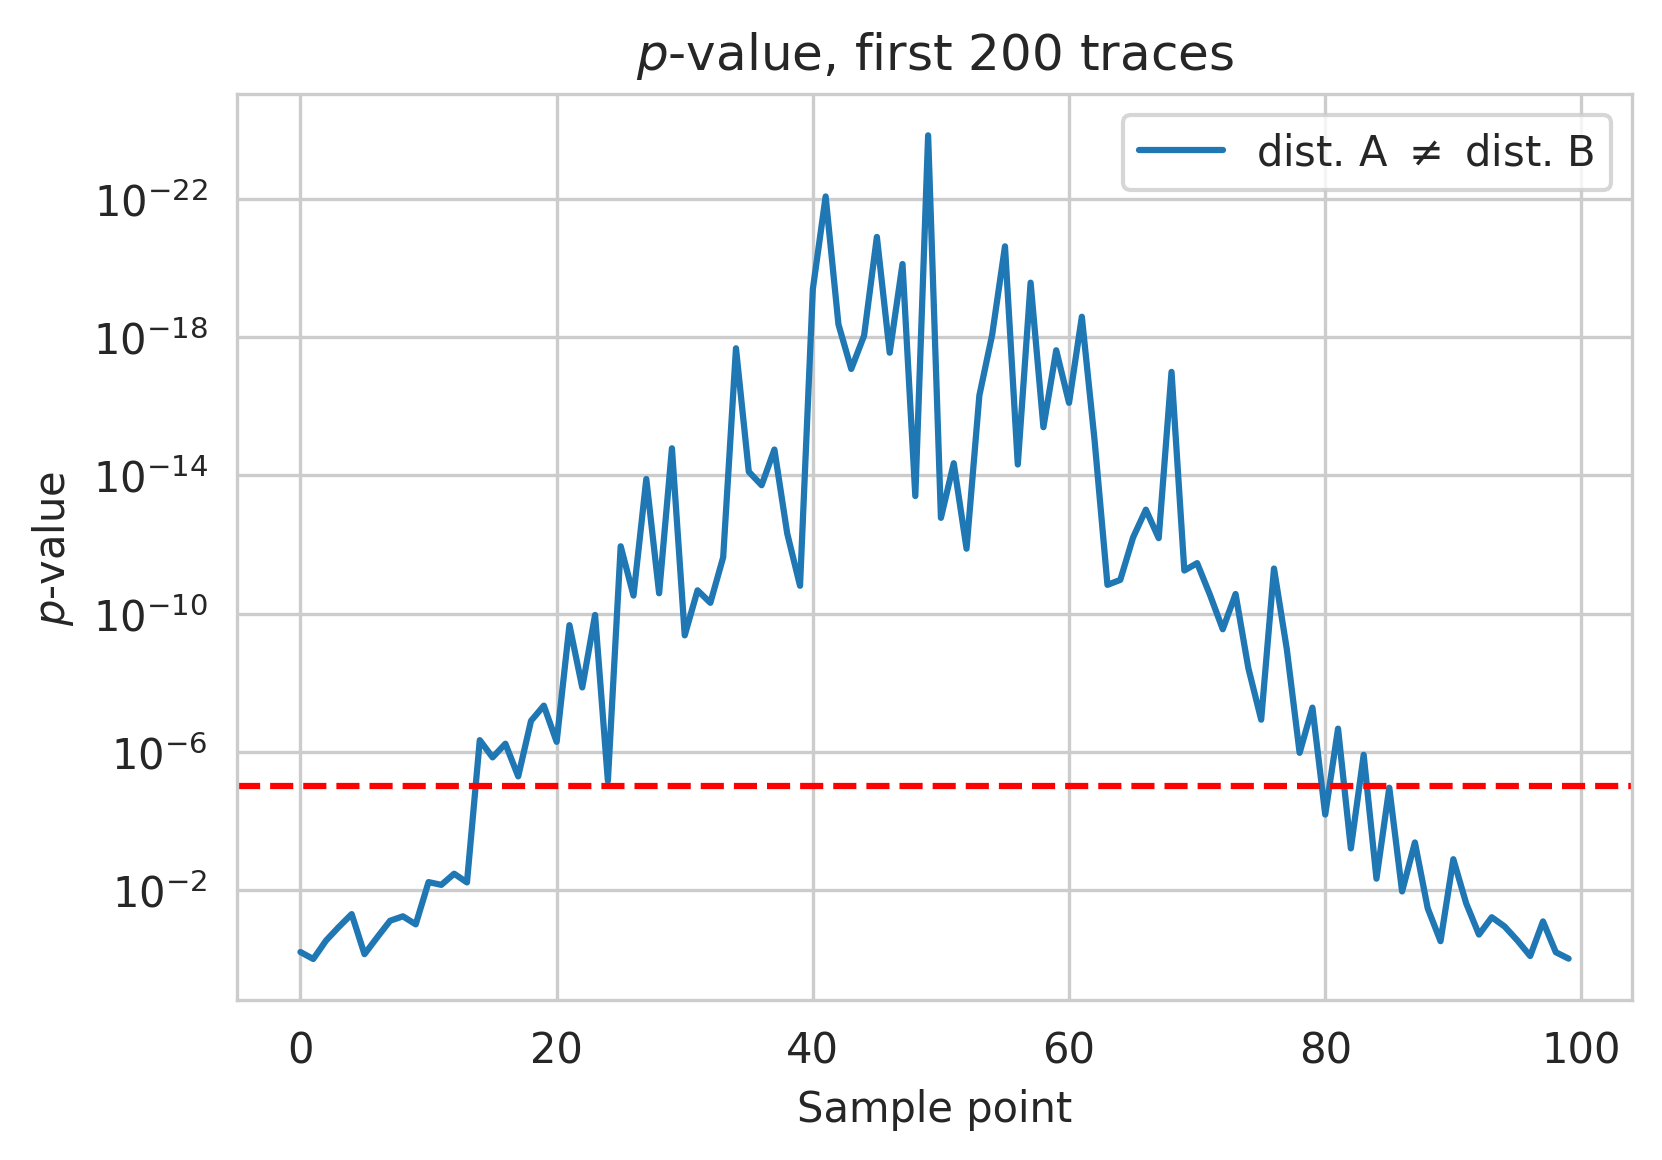

In [75]:
def get_min_ps():
    acc = []
    for ix in range(DISTS.shape[2]):
        acc.append(ttest_ind(DISTS[0, :200, ix], DISTS[1, :200, ix])[1])
    return acc

G = sns.lineplot(data={"dist. A $\\neq$ dist. B": get_min_ps()})
G.set(yscale="log", xlabel="Sample point", ylabel="$p$-value", title="$p$-value, first 200 traces")
G.invert_yaxis()

G.axhline(10 ** -5, ls='--', color="red")

Running t-tests: 100%|██████████| 199/199 [00:00<00:00, 1597.96it/s]


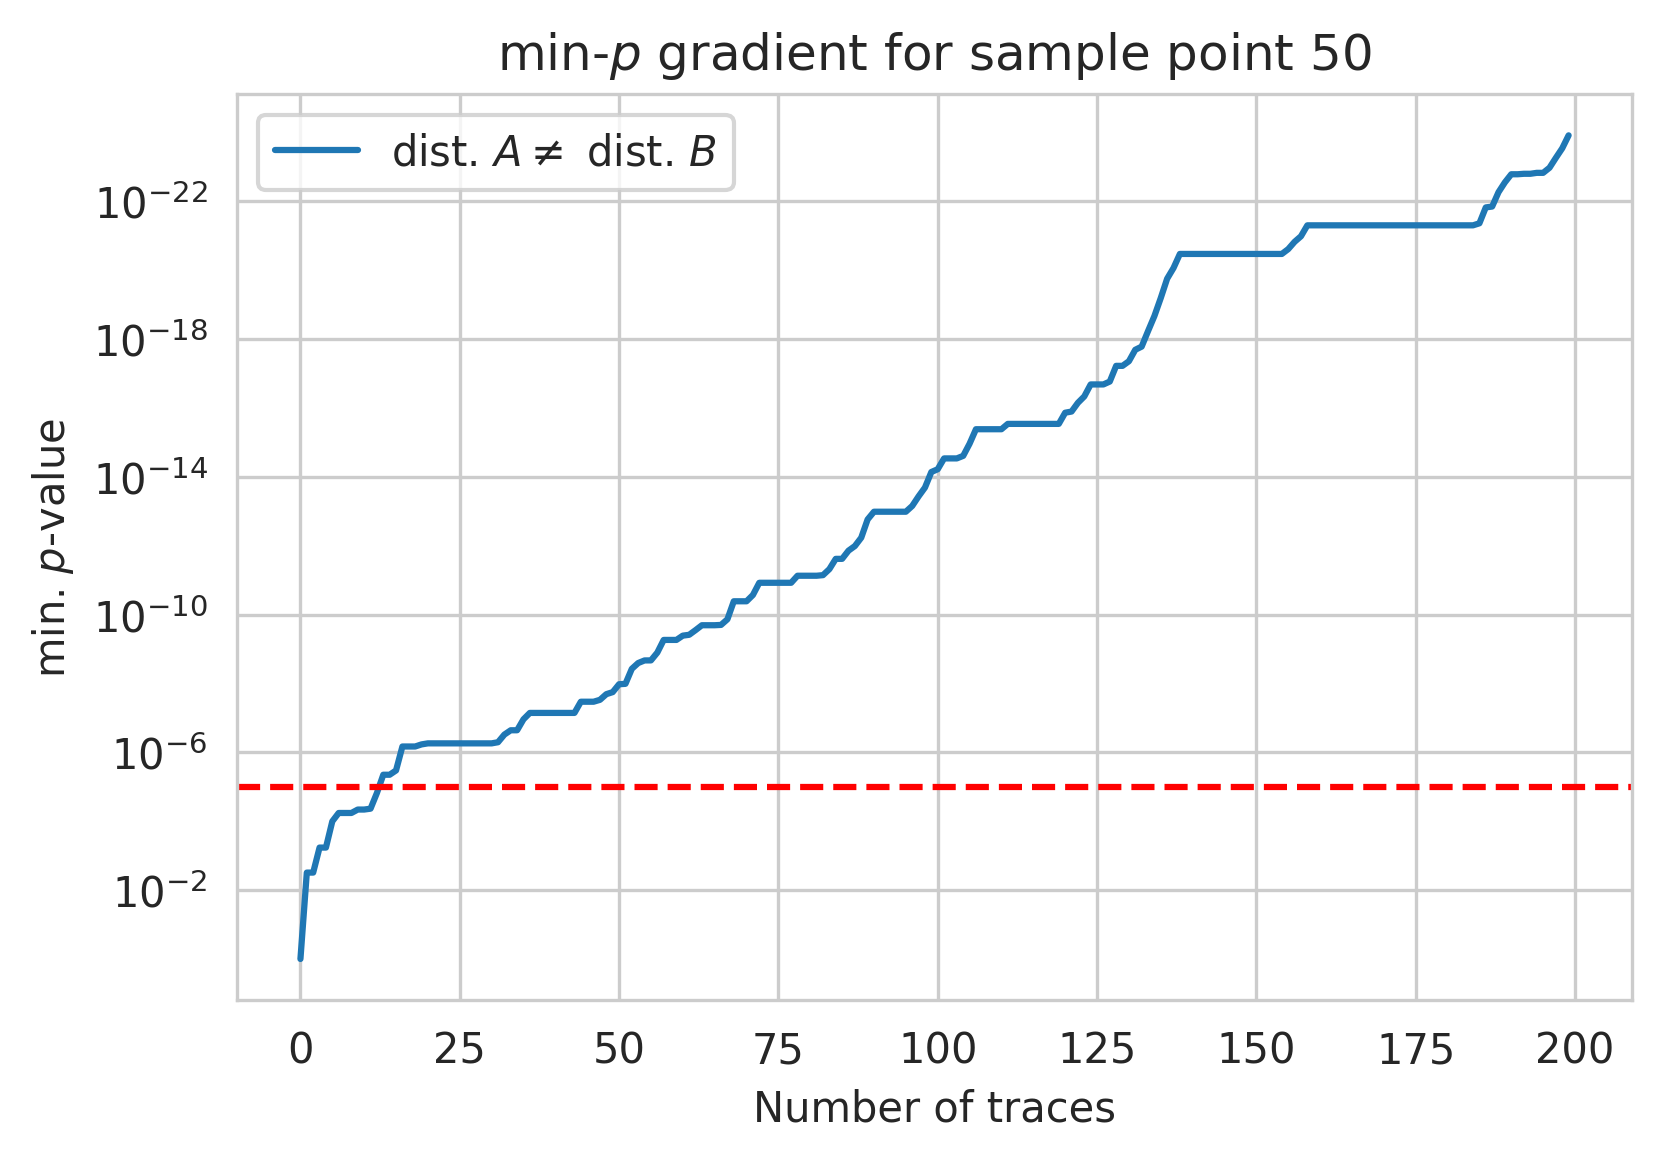

In [73]:
def min_p_gradient(a, b):
    """
    Calculates the min p-gradient for the t-test of two data sets.
    """
    accumulator = TvlaAccu(a.shape[1], make_test=make_t_test)
    accumulator.add(a, b)

    return accumulator.p_gradient

def plot_p_gradient(gradients: dict, title: str = "", max_traces: int = None, min_y: float = 10 ** -32):
    """
    Plots p-gradients.
    """
    sns.set_style('whitegrid')

    for k in gradients:
        gradients[k] = gradients[k][:max_traces]

    g = sns.lineplot(data=gradients)
    g.set(yscale="log", ylabel="min. $p$-value", xlabel="Number of traces",
          title=title)
    g.invert_yaxis()
    g.axhline(10 ** -5, ls='--', color="red")

plot_p_gradient({"dist. $A \\neq$ dist. $B$": min_p_gradient(DISTS[0, :200], DISTS[1, :200])}, title="min-$p$ gradient for sample point 50")